### 스태킹 앙상블

- 스태킹이 배깅, 부스팅과 다른 가장 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 것

  - 즉, 결과데이터셋을 최종 메타 데이터셋으로 만들어 별도의 알고리즘으로 최종 학습을 수행하고 테스트셋을 기반으로 다시 최종 예측을 수행하는 방식

  - 메타 모델: 개별 모델의 예측된 데이터셋을 다시 기반으로 하여 학습, 예측하는 방식

- 필요한 모델 2가지: 1. 개별적인 기반 모델 2. 최종 메타 모델

- 핵심은 >> 여러 개별 모델의 예측 데이터들을 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처데이터, 테스트용 피처데이터를 만드는것 <<

- 2~3개 모델만 결합한다고 성능을 높일 수 없어서 많은 모델 필요

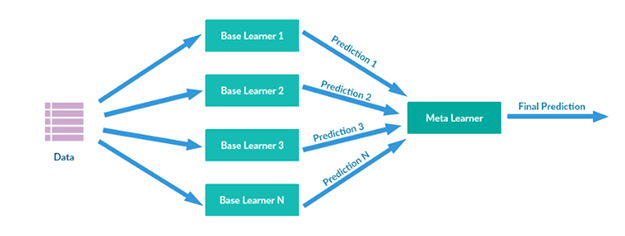

##### 기본 스태킹 모델

- 위스콘신 유방암 데이터 이용

In [1]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [2]:
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 예측 데이터셋을 학습, 예측할 최종 모델
lr_final = LogisticRegression()

#개별 모델 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

#학습된 개별 모델들이 각자 반환하는 예측 데이터셋을 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561


예측값들을 칼럼으로 붙여서 피처값으로 만들고 최종 메타 모델에 학습 데이터로 다시 사용하기

반환된 예측데이터셋은 1차원 ndarray이므로 먼저 반환된 예측 결과를 행 형태로 붙인 뒤, 넘파이의 transpose()를 이용하여 행과 열 위치를 바꿔주면된다

In [3]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


- 최종 메타 모델로 학습

In [4]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


스태킹으로 재구성하여 최종 학습한 결과, 정확도가 개별 모델모다 향상되었음

#### CV 세트 기반의 스태킹

- 과적합을 개선하기 위함

- 최종 메타 모델을 위한 데이터셋을 만들 때 교차 검증 기반으로 예측된 애들을 이용함

- Step1

각 모델별로 원본 학습/테스트 데이터를 예측한 결과값을 기반으로 메타 모델을 위한 학습/테스트 데이터를 생성한다

학습용 데이터를 N개의 Fold로 나눔 ex) 3개

① 3개 중 2개의 폴드는 학습을, 나머지 1개는 검증을 위한 폴드로 나눔, 2개의 폴드로 나뉜 학습데이터로 개별 모델 학습시킴

② 학습된 모델들을 1개의 검증 폴드 데이터로 예측하고 결과 저장함, 이런 로직을 학습/검증데이터 바꿔가며 3번 반복 >> 메타 모델용 학습데이터로 사용됨

③ 학습된 개별 모델들은 원본 테스트데이터를 예측하여 예측값 생성, 이런 로직을 3번 반복하면서 예측값의 평균을 냄, 이 평균으로 최종 결과값 생성, 얘를 최종 메타 모델용 테스트 데이터로 사용

- Step2

각 모델들이 step1으로 생성한 학습, 테스트데이터를 모두 합쳐서 최종 메타 모델이 사용할 학습, 테스트데이터를 만들어줌

최종 학습데이터와 원본 레이블데이터를 합쳐서 메타 모델 학습한 뒤 최종 테스트데이터로 예측하고 결과를 원본 레이블과 비교하며 평가하면됨

##### step1을 코드로 구현해보자

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 모델이 메타 모델용 학습, 테스트데이터를 생성하는 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  kf = KFold(n_splits=n_folds, shuffle=False)

  #추후에 메타 모델이 사용할 학습데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train)):
    #입력된 학습데이터에서 기반 모델이 학습, 예측할 폴드 데이터셋 추출
    print('\t 폴드 세트:', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    #폴드 세트 내부에서 다시 만들어진 학습데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)

    #폴드 세트 내부에서 다시 만들어진 검증데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)

    #입력된 원본 테스트데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균내고 테스트데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

  return train_fold_pred, test_pred_mean

각 모델별로 get_stacking_base_datasets()을 호출하여 추후에 메타 모델이 사용할 학습, 테스트용 데이터셋을 반환한다

In [6]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작


##### step2을 코드로 구현해보자

함수로 호출된 각 모델별 학습, 테스트 데이터를 합치기만 하면됌

In [10]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 shape:', X_train.shape, '원본 테스트 피처 shape:', X_test.shape)
print('스태킹 학습 피처 데이터 shape:', Stack_final_X_train.shape , '스태킹 테스트 피처 shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 shape: (455, 30) 원본 테스트 피처 shape: (114, 30)
스태킹 학습 피처 데이터 shape: (455, 4) 스태킹 테스트 피처 shape: (114, 4)


이렇게 만들어진 Stack_final_X_train, test는 메타 모델이 학습할 학습용, 테스트용 피처 데이터셋

4개의 개별 모델 예측값을 합친 것이므로 칼럼이 4개다

In [11]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


이 예제에서는 개별 모델마다 하이퍼 파라미터 튜닝을 따로 하지 않았지만 일반적으로 스태킹을 이루는 모델은 최적으로 튜닝한 상태에서 모델링 해야 함

스태킹 모델은 분류 뿐만 아니라 회귀에도 적용 가능함